# Magics

In [1]:
%load_ext autoreload

%autoreload 2

# Imports

In [2]:
import os
import gc
import configparser
import pathlib as p
import numpy as np
import seaborn as sns

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [4]:
import pandas as pd
pd.options.display.max_columns = 999

In [5]:
import torch

In [6]:
import clipper_python as clipper

In [7]:
import torch.nn as nn
import torch.optim as optim

In [8]:
from frag_nn.pytorch.network import GNINA_regressor, GNINA_regressor_v2, GNINA_regressor_v3, GNINA_regressor_v4, GNINA_regressor_v5, GNINA_regressor_v6, GNINA_regressor_v7, GNINA_regressor_v8
from frag_nn.data import XChemData
from frag_nn.pytorch.dataset import XChemDataset
import frag_nn.constants as c


# Get Config

In [9]:
config_path = "/dls/science/groups/i04-1/conor_dev/pandda_nn/frag_nn/params.ini"

In [10]:
conf = configparser.ConfigParser()

In [11]:
conf.read(config_path)

['/dls/science/groups/i04-1/conor_dev/pandda_nn/frag_nn/params.ini']

In [12]:
ds_conf = conf[c.x_chem_database]

In [13]:
grid_size = 48
grid_step = 0.5
network_version = 8
dataset_version = 2

# Load Database

In [14]:
x_chem_dataset = XChemData(host=ds_conf[c.db_host], 
                         port=ds_conf[c.db_port], 
                         database=ds_conf[c.db_database], 
                         user=ds_conf[c.db_user], 
                         password=ds_conf[c.db_password])


In [15]:
events = x_chem_dataset.get_database("pandda_event")

# Get accessible events

In [16]:
accessible_events_list = []

for pth in events["pandda_input_mtz"]:
    try:
        if p.Path(pth).exists():
            accessible_events_list.append(True)
        else:
            accessible_events_list.append(False)
            
    except PermissionError as e:
        accessible_events_list.append(False)


In [17]:
accessible_events_mask = np.array(accessible_events_list)

In [18]:
accessible_events = events[accessible_events_mask]

In [19]:
split = np.random.rand(len(accessible_events)) < 0.9

In [20]:
events_train = accessible_events[split]#
print(len(events_train))

1691


In [21]:
events_test = accessible_events[~split]
print(len(events_test))

180


In [22]:
events_train = pd.read_csv("new_events_train.csv")

/dls/science/groups/i04-1/conor_dev/anaconda/envs/env_pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
events_test = pd.read_csv("new_events_test.csv")

# Create Dataset

In [24]:
dataset_train = XChemDataset(events_train,
                              mode="RefMovev2",
                 grid_size=grid_size,
                 grid_step=grid_step,
                            replace_rate=1.0)

In [25]:
test_dataset = XChemDataset(events_test,
                             mode="RefMovev2",
                 grid_size=grid_size,
                 grid_step=grid_step,
                           replace_rate=1.0)

In [26]:
# x = dataset_train[10]["x"]

In [27]:
# x_2 = dataset_train[10]["x"]

In [28]:
# x_np_slice_2d = x[:, :, int(x.shape[2]/2)]

In [29]:
# x_np_slice_2d_2 = x_2[:, :, int(x.shape[2]/2)]

In [30]:
# plt.imshow(x_np_slice_2d)

In [31]:
# plt.imshow(x_np_slice_2d_2)

# Create Dataloaders

In [32]:
train_dataloader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=10, 
                                         shuffle=True,
                                         num_workers=10)

In [33]:
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=10, 
                                         shuffle=True,
                                         num_workers=10)

# Define Model

In [34]:
model = GNINA_regressor_v8(32,
                        grid_dimension=grid_size,
                          do_drop=False)

6912


In [55]:
model.load_state_dict(torch.load("model_params_{}_{}_{}_{}.pt".format(grid_size,
                                                             grid_step,
                                                                  network_version,
                                                                     dataset_version)))

In [56]:
print(model)

GNINA_regressor_v8(
  (conv_1): Sequential(
    (0): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_1): ResidualLayerWithDropx2(
    (conv_1): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (res_1): ResidualBlock(
      (conv_1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (res_2): ResidualBlock(
      (conv_1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine

# Define loss function

In [57]:
criterion = nn.MSELoss()

# Precision - Recall functions

In [58]:
def get_precision(y_hat, y, cutoff):
    
    positives_hat_mask = (y_hat > cutoff)
    negatives_hat_mask = (y_hat <= cutoff)
    
    positives_mask = (y == 1)
    negatives_mask = (y == 0)

    true_positives = np.count_nonzero(positives_hat_mask[positives_mask])
    false_positives = np.count_nonzero(positives_hat_mask[negatives_mask])
    
    total_predicted_positives = true_positives + false_positives
    
    if total_predicted_positives == 0:
        return 1
    
    precision = true_positives / total_predicted_positives
    
    return precision


In [59]:
def get_recall(y_hat, y, cutoff):
    positives_hat_mask = (y_hat > cutoff)
    negatives_hat_mask = (y_hat <= cutoff)

    positives_mask = (y == 1)
    negatives_mask = (y == 0)

    true_positives = np.count_nonzero(positives_hat_mask[positives_mask])
    false_negatives = np.count_nonzero(negatives_hat_mask[positives_mask])    

    total_positives = (true_positives + false_negatives)
    
    if total_positives == 0:
        return 0
    
    recall = true_positives / total_positives

    return recall

# Evaluate - Test Data

In [60]:
y_test = []
y_test_hat = []

In [61]:
for i, data in enumerate(test_dataloader):
    # get the inputs; data is a list of [inputs, labels]
    print("Iteration: {}".format(i))
    x = data["x"]
    y = data["y"]
#     x = x.unsqueeze(1)
    y = y.view(-1,1)
    
    outputs = model(x)
    
    y_test.append(y.detach())
    y_test_hat.append(outputs.detach())
#     optimizer.zero_grad()
    gc.collect()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [62]:
float(outputs[0])

0.042871031910181046

In [75]:
len(y_test)

237

In [64]:
len(y_test_hat)

[autoreload of frag_nn.pytorch.network failed: Traceback (most recent call last):
  File "/dls/science/groups/i04-1/conor_dev/anaconda/envs/env_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/dls/science/groups/i04-1/conor_dev/anaconda/envs/env_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/dls/science/groups/i04-1/conor_dev/anaconda/envs/env_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/dls/science/groups/i04-1/conor_dev/anaconda/envs/env_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/dls/science/groups/i04-1/conor_dev/anaconda/envs/env_pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 317, in update_insta

237

In [65]:
y = torch.cat(y_test)
y_hat = torch.cat(y_test_hat)

In [66]:
y.shape

torch.Size([2361, 1])

In [67]:
y_hat.shape

torch.Size([2361, 1])

In [68]:
# Get recall and precission for different cutoffs
points = []
for cutoff in np.linspace(0, 1, 100):
    precision = get_precision(y_hat, y, cutoff)
    recall = get_recall(y_hat, y, cutoff)
    points.append({"cutoff": cutoff,
                   "precision": precision, 
                   "recall":recall,
                  "num_predicted_positives": len(y_hat[y_hat > cutoff]),
                  "num_true_positives": len(y[y_hat > cutoff][y[y_hat > cutoff] == 1])})

In [69]:
stats = pd.DataFrame(points).set_index("cutoff")

In [70]:
stats

,num_predicted_positives,num_true_positives,precision,recall
cutoff,,,,
0.000000,2361,194,0.082169,1.000000
0.010101,2339,194,0.082941,1.000000
0.020202,2149,189,0.087948,0.974227
0.030303,1884,189,0.100318,0.974227
0.040404,1677,189,0.112701,0.974227
0.050505,1496,177,0.118316,0.912371
0.060606,1308,169,0.129205,0.871134
0.070707,1161,159,0.136951,0.819588
0.080808,1034,150,0.145068,0.773196


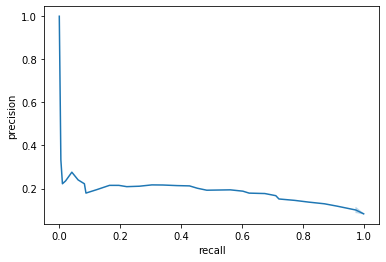

In [71]:
sns.lineplot(x="recall",
               y="precision",
               data=stats)

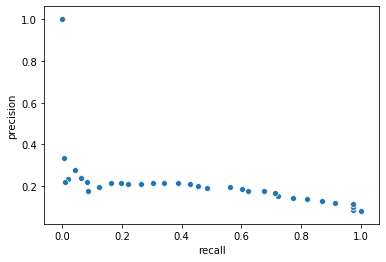

In [72]:
sns.scatterplot(x="recall",
               y="precision",
               data=stats,
            estimator=None)

In [73]:
stats.iloc[0].num_true_positives / stats.iloc[0].num_predicted_positives

0.08216857263871241

In [74]:
base_precision = len(events_test[events_test["Ligand Confidence"] == "High"]) / len(events_train)
base_precision

0.014759093505998857

# Evaluate - Train Data

In [ ]:
y_test = []
y_test_hat = []

In [ ]:
for i, data in enumerate(train_dataloader):
    # get the inputs; data is a list of [inputs, labels]
    print("Iteration: {}".format(i))
    x = data["x"]
    y = data["y"]
#     x = x.unsqueeze(1)
    y = y.view(-1,1)
    
    outputs = model(x)
    
    y_test.append(y.detach())
    y_test_hat.append(outputs.detach())
#     optimizer.zero_grad()
    gc.collect()

In [ ]:
y = torch.cat(y_test)
y_hat = torch.cat(y_test_hat)

In [ ]:
# Get recall and precission for different cutoffs
points = []
for cutoff in np.linspace(0, 1, 50):
    precision = get_precision(y_hat, y, cutoff)
    recall = get_recall(y_hat, y, cutoff)
    points.append({"cutoff": cutoff,
                   "precision": precision, 
                   "recall":recall})

In [ ]:
stats = pd.DataFrame(points).set_index("cutoff")

In [ ]:
stats

In [ ]:
sns.lineplot(x="recall",
               y="precision",
               data=stats,
            estimator=None)

In [ ]:
sns.scatterplot(x="recall",
               y="precision",
               data=stats,
            estimator=None)

In [ ]:
base_precision = len(events_train[events_train["ligand_confidence_inspect"] == "High"]) / len(events_train)
base_precision

In [ ]:
while True:
    time.sleep(60)

In [ ]:
torch.save(model.state_dict(), "model_params.pt")

# Inspect Model

In [ ]:
trace.history

In [ ]:
iterator = dataset.make_one_shot_iterator()

In [ ]:
x, y = iterator.next()

In [ ]:
x

In [ ]:
model.net(x)

In [ ]:
print(y)

In [ ]:
model.save_weights("model_32.h5")

In [ ]:
from torch.ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator

In [ ]:
trainer = create_supervised_trainer(model, optimizer, loss)

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def print